## Brownspot Dataset Cleaning and Aggregation
- Merge two or more datasets.
- Plot and verify image labels.
- Split datasest into train and test sets.

## Paths
- `LABELS` folder
- `IMAGES` folder

In [161]:
import json
import os
import csv
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import shutil
from pathlib import Path
from shutil import copyfile
from tqdm import tqdm

In [210]:
def get_json(dir):
    """Get *.json files in dir."""
    jsons = []
    for file in os.listdir(dir):
        if file.endswith(".json"):
            jsons.append(os.path.join(dir, file))
    return jsons

def process_coco_json(jsons):
    """EXtracts the image file_name and it's bounding box to a dataframe."""

    df = pd.DataFrame(columns=['file_name',
                                'xmin',
                                'ymin',
                                'width',
                                'height'])

    # Extract
    for file in tqdm(jsons, desc="Processing *.json: "):
        f = open(file, 'r')
        data = json.load(f)
        f.close()

        # Files
        files = data["images"]
        annotations = data["annotations"]

        for file in files:
            # Get file_name
            image_id = file["id"]

            for annotation in annotations:
                if image_id == annotation["image_id"]:
                    bbox = annotation["bbox"]
                    df = df.append({"file_name": file["file_name"],
                                    "xmin": bbox[0],
                                    "ymin": bbox[1],
                                    "width": bbox[2],
                                    "height": bbox[3]},
                                    ignore_index=True)
    return df

def process_labelbox_json(jsons):
    """
        Parse Labelbox labels JSON.
    """
    df = pd.DataFrame(columns=['file_name',
                                'xmin',
                                'ymin',
                                'width',
                                'height'])
    
    # Extract
    for file in jsons:
        f = open(file, 'r')
        data = json.load(f)
        f.close()
        
        for item in tqdm(data, desc="Processing data: "):
            # print ('Working')
            item_label = item['Label']

            # check if the item['Label'] is empty. If empty, continue to the next item.
            if bool(item_label)==False:
                continue

            # check if the item['Label']['objects'] is empty, if so, proceed to the next item.
            elif bool(item_label['objects']==False):
                continue

            # All  is well, execute the loop below for all the bounding boxes.
            #Image file_name
            file_name = item['External ID']

            #Extract the bounding boxes
            for bounding_box in item_label['objects']:
                # print(dictionary['bbox'])

                # class_name = bounding_box['title'].replace(" ", "")

                ymin = bounding_box['bbox']['top']
                xmin = bounding_box['bbox']['left']

                height = bounding_box['bbox']['height']
                width = bounding_box['bbox']['width']

                df = df.append({"file_name": file_name,
                                "xmin": xmin,
                                "ymin": ymin,
                                "width": width,
                                "height": height},
                                ignore_index=True)
            
    return df


def make_dirs(dirs):
    """Make directories that don't exist."""
    for dir in dirs:
        if not os.path.isdir(dir):
            os.mkdir(dir)
            

def split_indices(x, train=0.8, test=0.0, validate=0.2, shuffle=True):  
    # split training data
    n = len(x)
    v = np.arange(n)
    if shuffle:
        np.random.shuffle(v)

    i = round(n * train)  # train
    j = round(n * test) + i  # test
    k = round(n * validate) + j  # validate
    return v[:i], v[i:j], v[j:k]  # return indices

def split_files(file_names,train=0.8, test=0.2, validate=0.0):  # split training data
    file_name = list(filter(lambda x: len(x) > 0, file_names))
    file_name = sorted(file_name)
    i, j, k = split_indices(file_names, train=train, test=test, validate=validate)
    train = []
    test = []
    val = []
    datasets = {'train': i, 'test': j, 'val': k}
    for key, item in datasets.items():
        if item.any():
            for ix in item:
                if key == 'train':
                    train.append(file_names[ix])
                if key == 'test':
                    test.append(file_names[ix])
                if key == 'val':
                    val.append(file_names[ix])

    return train, test, val

# create coco file
def make_coco_file(labels, categories, filenames):
    """Creates a COCO format data structure."""

    classes = sorted(categories)
    category_list = []

    # COCO ANNOTATION FORMAT
    for i, category in enumerate(classes):
        foo = {}
        foo["supercategory"] = "None"
        foo["id"] = i + 1 # COCO is one-indexed
        foo["name"] = category
        category_list.append(foo)

    # COCO VARIABLE
    COCO_DATA = {}
    COCO_DATA["type"] = "instances"
    COCO_DATA["images"] = []
    COCO_DATA["annotations"] = []
    COCO_DATA["categories"] = category_list

    image_id = 0 # Image id
    annotation_id = 0 # Annotation id

    label = "brownspot" # Different implementation for more than one label

    # Iterate through the filenames
    for file_name in tqdm(filenames, desc="Creating COCO: "):

        # Add to COCO images
        temp = {}
        temp["file_name"] = file_name
        temp["height"] = 400 # Could be dynamic
        temp["width"]  = 400
        temp["id"]  = image_id
        COCO_DATA["images"].append(temp)

        # Bboxes
        image_bboxes = labels[labels.file_name == file_name]

        for _, row in image_bboxes.iterrows():
            xmin = float(row["xmin"])
            ymin = float(row["ymin"])
            width = float(row["width"])
            height = float(row["height"])

            temp = {}
            temp["id"] = annotation_id
            annotation_id += 1
            temp["image_id"] = image_id
            temp["segmentation"] = []
            temp["ignore"] = 0
            temp["area"] = width * height
            temp["iscrowd"] = 0
            temp["bbox"] = [xmin, ymin, width, height]
            temp["category_id"] = classes.index(label) + 1 # There is only one class
            COCO_DATA["annotations"].append(temp)
        # Update image id
        image_id += 1

    # Return coco data format
    return COCO_DATA

def create_file(coco_data, output_file):
    """Create JSON file of the COCO_DATA."""
    f = open(output_file, 'w')
    json_str = json.dumps(coco_data, indent=4)
    f.write(json_str)
    f.close()
    
def move_files(files, source, dest):
    """
        Move files from the source directory to the destination directory.
    """
    for filename in files:
        copyfile(os.path.join(source, filename),
                 os.path.join(dest, filename))
        
def create_yolo_labels(labels, dir, filenames, kind):
    """
        Create yolo labels for each image.
    """
    yolo_directory = os.path.join(dir, kind)
    make_dirs([yolo_directory])
    
    for file_name in tqdm(filenames, desc='Images'):
        #name of file to save the bounding box items
        label_name = str(f'{Path(file_name).stem}.txt')
        
        image_width, image_height = 400, 400

        #create label file for current image
        with open(os.path.join(yolo_directory, label_name), 'w') as file:

            # Bboxes
            image_bboxes = labels[labels.file_name == file_name]
            
            for _, row in image_bboxes.iterrows():
                xmin = float(row["xmin"])
                ymin = float(row["ymin"])
                width = float(row["width"])
                height = float(row["height"])
            
                   
                xmax = xmin + width
                ymax = ymin + height

                x_center = 0.5*(xmin + xmax)
                y_center = 0.5*(ymin + ymax)

                #Normalize with image dimensions
                x_center_norm =  x_center/image_width
                width_norm = width/image_width

                y_center_norm = y_center/image_height
                height_norm = height/image_height
                # <object-class> <x> <y> <width> <height> Note <> - normalized
                file.write('%g %.6f %.6f %.6f %.6f\n' % (0, x_center_norm, y_center_norm,
                                                     width_norm, height_norm))
                
                
def to_csv(labels, filenames, kind):
    """
        Save CSV files.
    """
    dir_path = os.path.join(OUTPUT_DIR, 'CSV')
    make_dirs([dir_path])
    csv_name = f'{kind}_labels.csv'
    df = pd.DataFrame()
    
    for file in tqdm(filenames, desc="Processing *.csv"):
        temp = labels[labels.file_name == file]
        df = df.append(temp, ignore_index=True)
        
    df.to_csv(os.path.join(dir_path, csv_name), index=False)

def save_file_lists(dir, files, kind):
    """
        Saves the test|train filenames to disc.
    """
    with open(os.path.join(dir, f'{kind}.txt'), 'w') as file:
        for item in files:
            file.write('%s\n' % item)
            
# Display utilities
def process_images(filenames, labels, r_images):
    n = np.arange(len(filenames))
    np.random.shuffle(n)
    indices = np.random.choice(n, r_images)
    
    temp = [] # Holds the random images
    
    # Extract information
    for index in indices:
        # Probably inefficient
        file_name = filenames[index]
        image_id = file_name.split('/')[-1]
        
        # Bboxes
        image_bboxes = labels[labels.file_name == image_id]
        
        bboxes = []
        for _, row in image_bboxes.iterrows():
                xmin = float(row["xmin"])
                ymin = float(row["ymin"])
                width = float(row["width"])
                height = float(row["height"])
                
                bboxes.append([xmin, ymin, width, height])
        temp.append((file_name, bboxes))
    # Return a pair of the filename and it's bounding boxes.
    return temp

def display_image(image, bboxes, subplot):
    """Display a single image."""
    ax = plt.subplot(*subplot)
    plt.axis('off')
    
    for bbox in bboxes:
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], \
                                 linewidth=1, edgecolor='w', facecolor='none')
        ax.add_patch(rect)
    ax.imshow(image)
    return (subplot[0], subplot[1], subplot[2] + 1)

def display_images(files):
    """Displays a batch of images."""
    rows = int(math.sqrt(len(files)))  
    cols = len(files) // rows
    
    FIGSIZE = 13.0
    SPACING = 0.1
    
    subplot = (rows, cols, 1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE, FIGSIZE / cols * rows))
    else:
        plt.figure(figsize=(FIGSIZE / rows * cols, FIGSIZE))
    
    for file, bboxes in files[:rows * cols]:
        image = Image.open(file)
        subplot = display_image(image, bboxes, subplot)
        
    plt.tight_layout()
    plt.show()

## Script Body

In [205]:
# Existing directories
CWD = os.getcwd()
OUTPUT_DIR = os.path.join(CWD, 'dataset')
DATASET_DIR = os.path.join(CWD, 'images')
COCO_JSONS_DIR = os.path.join(CWD, 'labels')
LABEL_BOX_JSONS = os.path.join(CWD, 'labelbox')

# Directories to make.
TRAIN_DIR = os.path.join(OUTPUT_DIR, 'train')
TEST_DIR = os.path.join(OUTPUT_DIR, 'test')
VAL_DIR = os.path.join(OUTPUT_DIR, 'val')
COCO_DIR = os.path.join(OUTPUT_DIR, 'COCO')
YOLO_DIR = os.path.join(OUTPUT_DIR, 'YOLO')

In [206]:
# 1.0 Prepare folders.
dirs =  [OUTPUT_DIR, TRAIN_DIR, VAL_DIR, TEST_DIR, COCO_DIR, YOLO_DIR]
make_dirs(dirs)

In [175]:
# 2.0 Get all the *.json
coco_jsons = get_json(COCO_JSONS_DIR)
coco_df = process_coco_json(coco_jsons)

Processing *.json: 100%|██████████| 3/3 [00:12<00:00,  4.09s/it]


In [176]:
coco_df.shape

(4303, 5)

In [177]:
labelbox_jsons = get_json(LABEL_BOX_JSONS)
labelbox_df = process_labelbox_json(labelbox_jsons)

Processing data: 100%|██████████| 3225/3225 [00:57<00:00, 55.72it/s]


In [178]:
labelbox_df.shape

(14077, 5)

In [179]:
df = coco_df.append(labelbox_df, ignore_index=True)
df.shape

(18380, 5)

In [180]:
file_names = list(df.file_name.unique())
len(file_names)

4562

In [181]:
files = []
for file_name in file_names:
    files.append(os.path.join(DATASET_DIR, file_name))

## Visualization Test

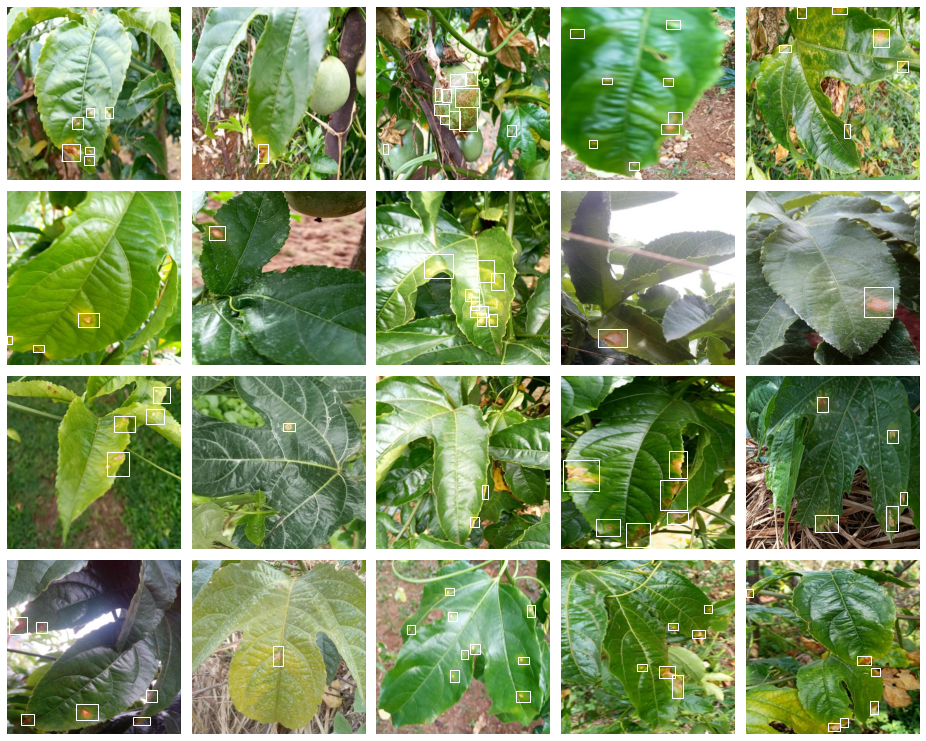

In [182]:
dumps = process_images(files, df, 21)
display_images(dumps)

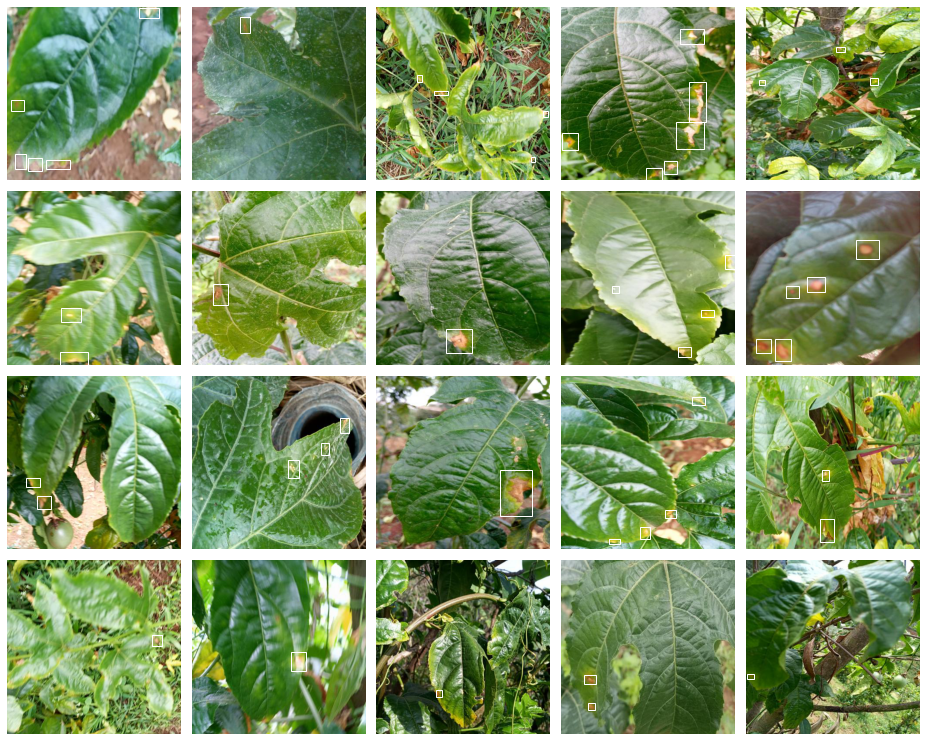

In [183]:
dumps = process_images(files, df, 21)
display_images(dumps)

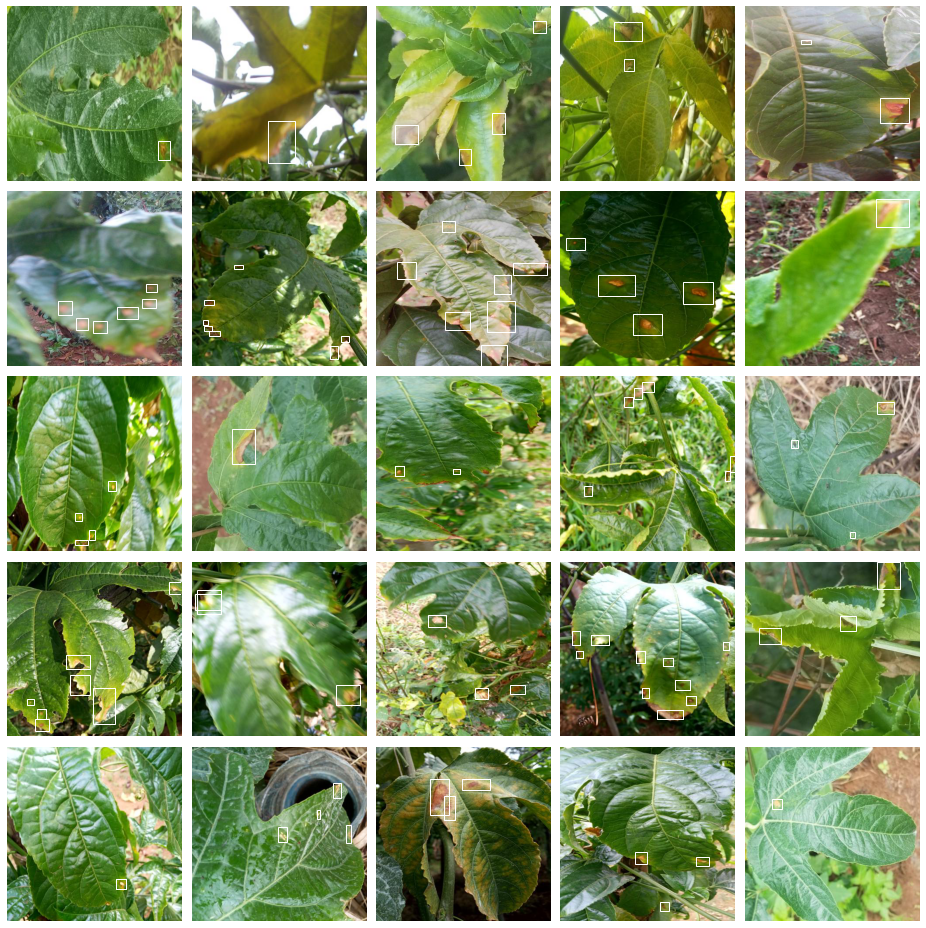

In [184]:
dumps = process_images(files, df, 27)
display_images(dumps)

Random checks passed.

## Dataset Curation

In [192]:
100/4562, 1 - 0.022

(0.021920210434020166, 0.978)

In [224]:
# 3.0 Split the images into train, test, val
train, test, val = split_files(file_names,train=0.978, test=0.022, validate=0.0)

In [225]:
len(test), len(train), len(val)

(100, 4462, 0)

In [195]:
# 4.0 Create the COCO format *.json
categories = ['brownspot']

In [196]:
TRAIN_COCO = make_coco_file(df, categories, train)
output_annotation_file = os.path.join(COCO_DIR, "instances_train.json")
create_file(TRAIN_COCO, output_annotation_file)

Creating COCO: 100%|██████████| 4462/4462 [00:10<00:00, 417.04it/s]


In [197]:
TEST_COCO = make_coco_file(df, categories, test)
output_annotation_file = os.path.join(COCO_DIR, "instances_test.json")
create_file(TEST_COCO, output_annotation_file)

Creating COCO: 100%|██████████| 100/100 [00:00<00:00, 394.17it/s]


In [198]:
create_yolo_labels(df, YOLO_DIR, train, 'train')

Images: 100%|██████████| 4462/4462 [00:11<00:00, 392.92it/s]


In [199]:
create_yolo_labels(df, YOLO_DIR, test, 'test')

Images: 100%|██████████| 100/100 [00:00<00:00, 332.81it/s]


In [200]:
# Save files to disc
save_file_lists(OUTPUT_DIR, train, 'train')
save_file_lists(OUTPUT_DIR, test, 'test')

In [211]:
to_csv(df, train, 'train')

Processing *.csv: 100%|██████████| 4462/4462 [00:12<00:00, 356.52it/s]


In [212]:
to_csv(df, test, 'test')

Processing *.csv: 100%|██████████| 100/100 [00:00<00:00, 375.16it/s]


In [214]:
# Finally, move the files.
move_files(train, DATASET_DIR, TRAIN_DIR)

In [215]:
move_files(test, DATASET_DIR, TEST_DIR)

## Create Moses's Efficientdet set

In [226]:
train, test, val = split_files(train,train=0.9, test=0.0, validate=0.1)

In [227]:
len(train), len(test), len(val)

(4016, 0, 446)

In [229]:
TRAIN_COCO = make_coco_file(df, categories, train)
output_annotation_file = os.path.join(COCO_DIR, "instances_train.json")
create_file(TRAIN_COCO, output_annotation_file)

Creating COCO: 100%|██████████| 4016/4016 [00:11<00:00, 343.44it/s]


In [230]:
VAL_COCO = make_coco_file(df, categories, val)
output_annotation_file = os.path.join(COCO_DIR, "instances_val.json")
create_file(VAL_COCO, output_annotation_file)

Creating COCO: 100%|██████████| 446/446 [00:01<00:00, 354.44it/s]


In [232]:
move_files(val, DATASET_DIR, VAL_DIR)

In [234]:
move_files(train, DATASET_DIR, TRAIN_DIR)